![image.png](images/ensemble_learning.png)

## 投票法

### 1. 硬投票和软投票哪种方式更好？
投票法分为硬投票和软投票两种方式，有些情况下，两种方式可以得出完全不同的结论。  
因此，一般情况下，优先使用**软投票**方式，因为它给与那些高度自信的投票更高的权重。
### 2. 基模型的选取
* 基模型之间的效果不能差别太大，如果某个基模型的效果相对太差的话，有可能会改变预测结果；
* 基模型之间的应该有较小的同质性，应该使用多种相互独立，不同算法的分类器。

### 基于sklearn的投票法案例
* 分类 VotingClassifier
* 回归 VotingRegressor

In [21]:
# 导入库
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot

In [24]:
# 创建样本数据
from sklearn.datasets import make_classification
def get_datasets(n_samples, n_informative, n_redundant):
    """
    make_classification(), 随机产生分类数据：
    n_samples:样本数量
    n_features:特征数量
    n_informative: 有用特征数量
    n_redundant: 冗余特征数量
    n_classes: 类别数量
    """
    X,y = make_classification(n_samples=n_samples, n_features=20, n_informative=n_informative, 
                              n_redundant=n_redundant, random_state=2)
    return X,y

In [29]:
# 创建基模型, 使用KNN
def get_basic_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['lr'] = LogisticRegression()
    models['svm'] = SVC(probability=True)
    return models

In [10]:
# 创建投票模型
def get_emsemble_voting_model(voting_type='soft'):
    basic_models = get_basic_models()
    # estimators,接收 tuple
    ensemble_model = VotingClassifier(estimators=tuple(basic_models.items()), voting=voting_type)

    return ensemble_model

In [11]:
# 整合投票模型和基模型，以便于评价集成模型的性能
def get_models():
    models = get_basic_models()
    models["soft_voting"] = get_emsemble_voting_model('soft')
    models["hard_voting"] = get_emsemble_voting_model('hard')
    
    return models

In [15]:
# 创建函数，交叉验证训练模型
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>knn1 0.901 (0.019)
>knn3 0.924 (0.018)
>knn5 0.932 (0.016)
>knn7 0.932 (0.017)
>knn9 0.928 (0.020)
>lr 0.817 (0.027)
>svm 0.934 (0.018)
>soft_voting 0.937 (0.013)
>hard_voting 0.936 (0.015)


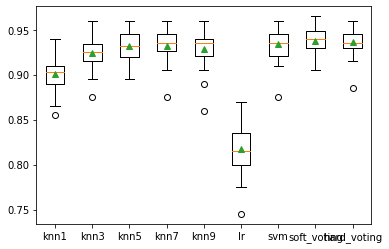

In [31]:
# 开始训练
# initial
X,y = get_datasets(n_samples=2000, n_informative=15, n_redundant=5)
models = get_models()

# train and evaluate
results, names = [], []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**按照Baseline，基模型只用KNN，可能并不能体现出集成模型的性能优点。**   
**加入了两种不同的基模型后，可以看到集成的准确率相对于基模型更高，而且有更低的方差。**